In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("esg_dataset.csv")

In [3]:
df.head()

,company_id,company_name,year,industry,region,revenue,net_profit,total_assets,total_liabilities,equity,...,audit_opinion,fraud_risk_score,g_index,esg_score,stock_volatility,market_cap,ownership_type,risk_category,audit_firm,financial_health_index
0,SH969694,Haier Precision Ltd.,2022,Manufacturing,Sichuan,10842.32,1941.90,16828.60,6075.45,10753.15,...,Qualified,0.37,1,61,0.18,32356.57,Private,Low,Big4,0.15
1,SH319685,Guangzhou Pharma Group,2022,Pharmaceuticals,Hebei,10645.28,522.59,15085.21,10776.40,4308.81,...,Standard,0.18,2,61,0.33,28095.09,Private,Low,Local Tier 1,0.08
2,SZ694732,Sinopec Green Energy,2022,Energy,Sichuan,8993.79,2226.45,13173.37,4370.65,8802.72,...,Standard,0.74,8,63,0.36,21973.57,Private,High,Local Tier 2,0.21
3,SZ358608,Guangzhou Pharma Group,2022,Pharmaceuticals,Hebei,5305.38,1238.70,8370.68,3011.75,5358.93,...,Standard,0.56,10,42,0.57,11651.27,SOE,Medium,Local Tier 1,0.19
4,SZ245052,CRRC Urban Transit,2021,Transportation,Jiangsu,9084.19,2759.81,16503.92,9025.96,7477.96,...,Standard,0.42,2,57,0.25,28162.58,Private,Medium,Local Tier 1,0.27


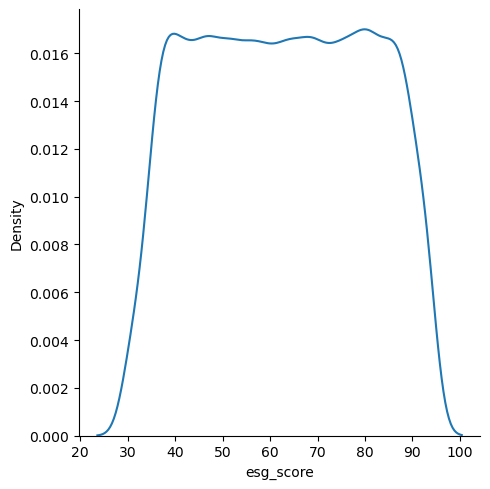

In [50]:
sns.displot(df, x="esg_score", kind="kde")

In [70]:
# Identify numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols]

Top factors correlated with ESG score:
year                   :  0.1143
profit_margin          :  0.0318
anomaly_label          : -0.0306
net_profit             :  0.0290
operating_cash_flow    :  0.0264
equity                 :  0.0232
roa                    :  0.0231
total_assets           :  0.0203
market_cap             :  0.0179
financial_health_index :  0.0162


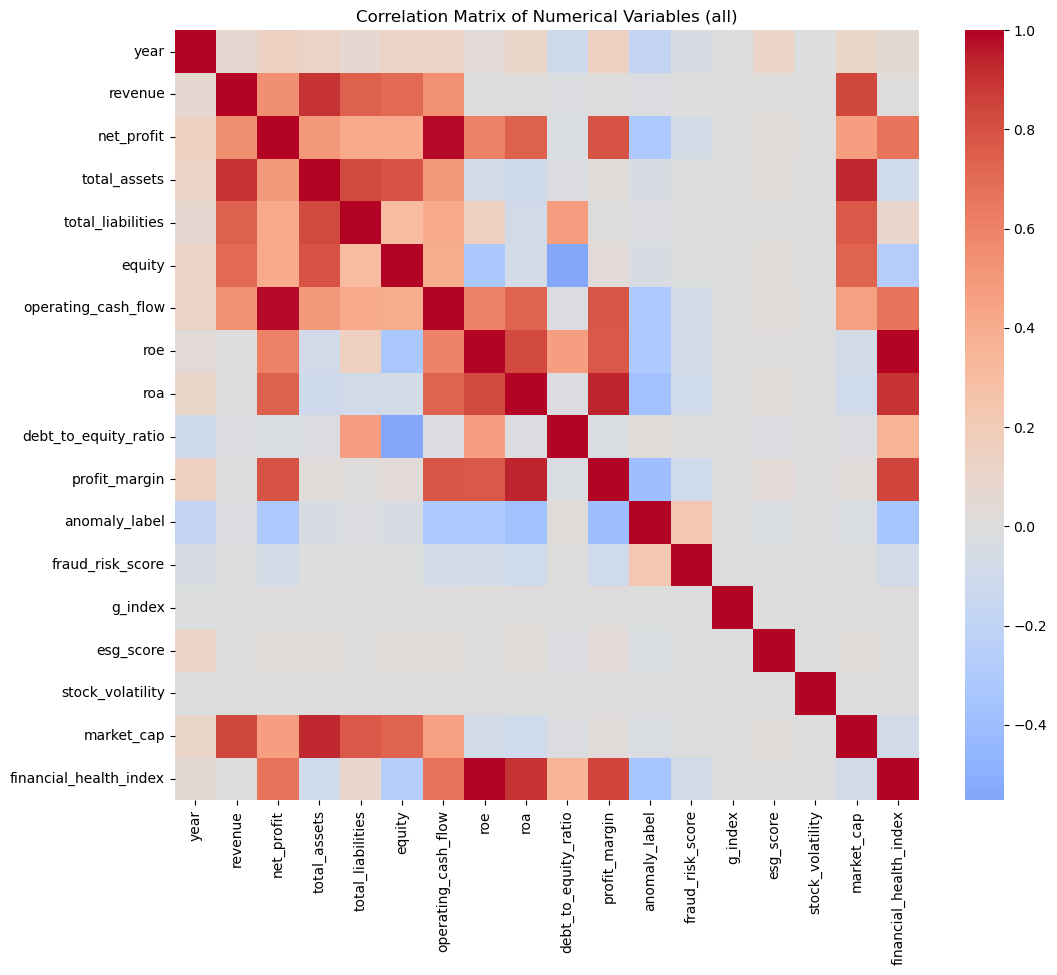

In [99]:
# Calculate correlations with ESG score
correlations = df[numerical_cols].corr()['esg_score'].drop('esg_score').sort_values(key=abs, ascending=False)

print("Top factors correlated with ESG score:")
for factor, corr in correlations.head(10).items():
    print(f"{factor:23}: {corr:>7.4f}")

# Visualization: Correlation heatmap
plt.figure(figsize=(12, 10))
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Variables (all)')
plt.show()

In [142]:
# Detect variables with high multicollinearity
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Initialize lists
variables_to_remove = []
remaining_vars = numerical_cols.copy()

# Iteratively remove high VIF variables
while True:
    # Define the predictor variables
    X = df[remaining_vars]
    # Add a constant to the model (intercept)
    X = add_constant(X)
    # Calculate VIF for each feature
    vif = pd.DataFrame()
    vif['Feature'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Find max VIF (excluding constant)
    vif_no_const = vif[vif['Feature'] != 'const']
    max_vif = vif_no_const['VIF'].max()
    
    if max_vif <= 10:
        print("No more variables with VIF > 10")
        break
    
    # Check which variables have VIF > 10
    high_vif_vars = []
    for index, row in vif.iterrows():
        feature = row['Feature']
        vif_value = row['VIF']
        if vif_value > 10 and feature != 'const':
            high_vif_vars.append(feature)
    
    # Remove variable with highest VIF
    var_to_remove = vif_no_const.loc[vif_no_const['VIF'].idxmax(), 'Feature']
    variables_to_remove.append(var_to_remove)
    remaining_vars.remove(var_to_remove)
    print(f"Removing {var_to_remove} (VIF = {max_vif:.2f})")
    
    if len(remaining_vars) <= 1:
        break

print(f"\nFinal variables: {remaining_vars}")
print(f"Removed variables: {variables_to_remove}")

Removing total_assets (VIF = inf)
Removing financial_health_index (VIF = 1423.46)
Removing net_profit (VIF = 50.95)
Removing roa (VIF = 36.88)
Removing profit_margin (VIF = 12.90)
No more variables with VIF > 10

Final variables: ['year', 'revenue', 'total_liabilities', 'equity', 'operating_cash_flow', 'roe', 'debt_to_equity_ratio', 'anomaly_label', 'fraud_risk_score', 'g_index', 'esg_score', 'stock_volatility', 'market_cap']
Removed variables: ['total_assets', 'financial_health_index', 'net_profit', 'roa', 'profit_margin']


Top factors correlated with ESG score (after VIF cleaning):
year                     :  0.1143
anomaly_label            : -0.0306
operating_cash_flow      :  0.0264
equity                   :  0.0232
market_cap               :  0.0179
debt_to_equity_ratio     : -0.0138
roe                      :  0.0130
total_liabilities        :  0.0101
revenue                  :  0.0100
fraud_risk_score         : -0.0071


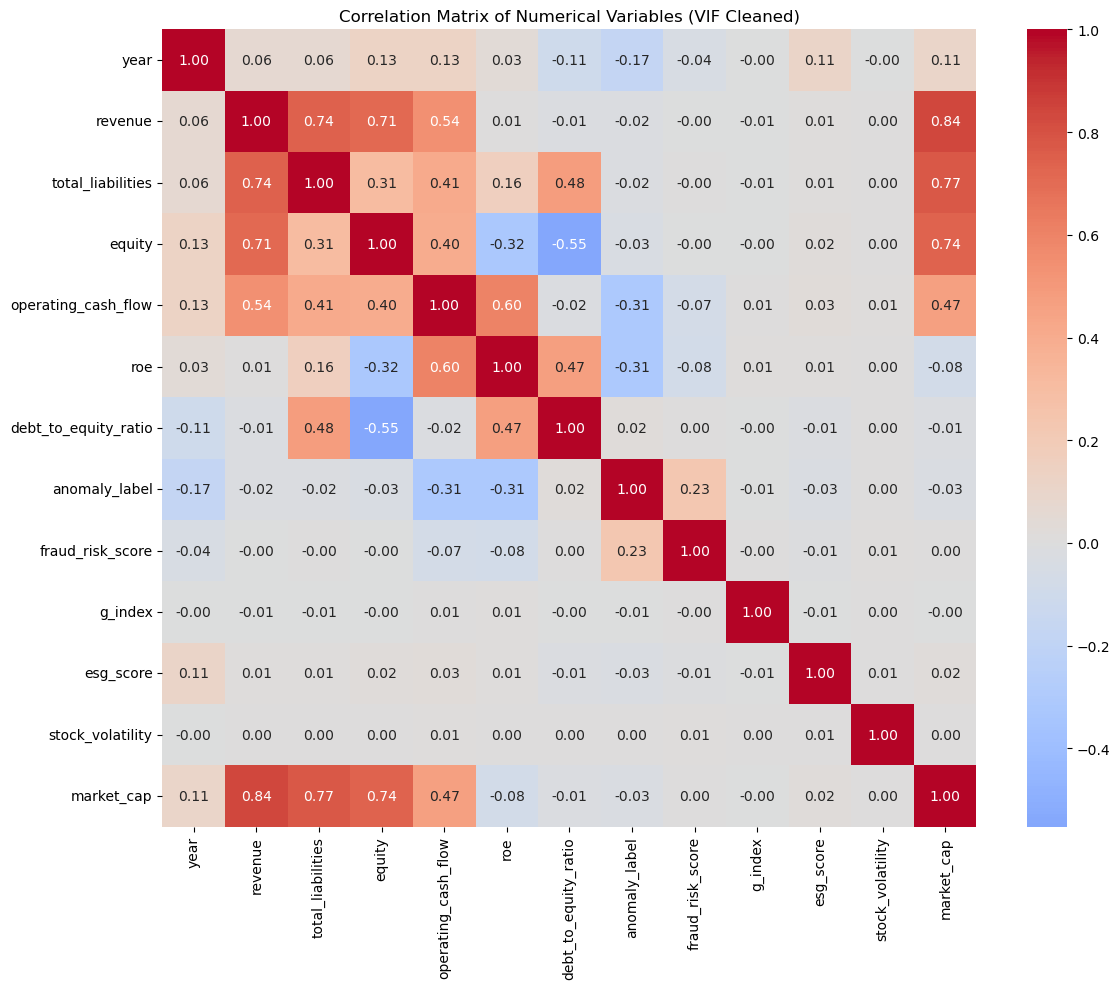

In [157]:
# Calculate correlations with ESG score using cleaned variables
cleaned_cols = remaining_vars  # Add esg_score back for correlation analysis
correlations = df[cleaned_cols].corr()['esg_score'].drop('esg_score')

# Safe sorting approach - works for both Series and DataFrame
if isinstance(correlations, pd.Series):
    # Sort by absolute value but keep original correlation values
    correlations_sorted = correlations.loc[correlations.abs().sort_values(ascending=False).index]
else:
    # If it's a DataFrame (shouldn't happen but just in case)
    correlations_sorted = correlations.iloc[:, 0].loc[correlations.iloc[:, 0].abs().sort_values(ascending=False).index]

print("Top factors correlated with ESG score (after VIF cleaning):")
for factor, corr in correlations_sorted.head(10).items():
    print(f"{factor:<25}: {corr:>7.4f}")

# Visualization: Correlation heatmap with cleaned variables
plt.figure(figsize=(12, 10))
corr_matrix = df[cleaned_cols].corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True, fmt='.2f')
plt.title('Correlation Matrix of Numerical Variables (VIF Cleaned)')
plt.tight_layout()
plt.show()


But your original code should work correctly with most recent versions of pandas.

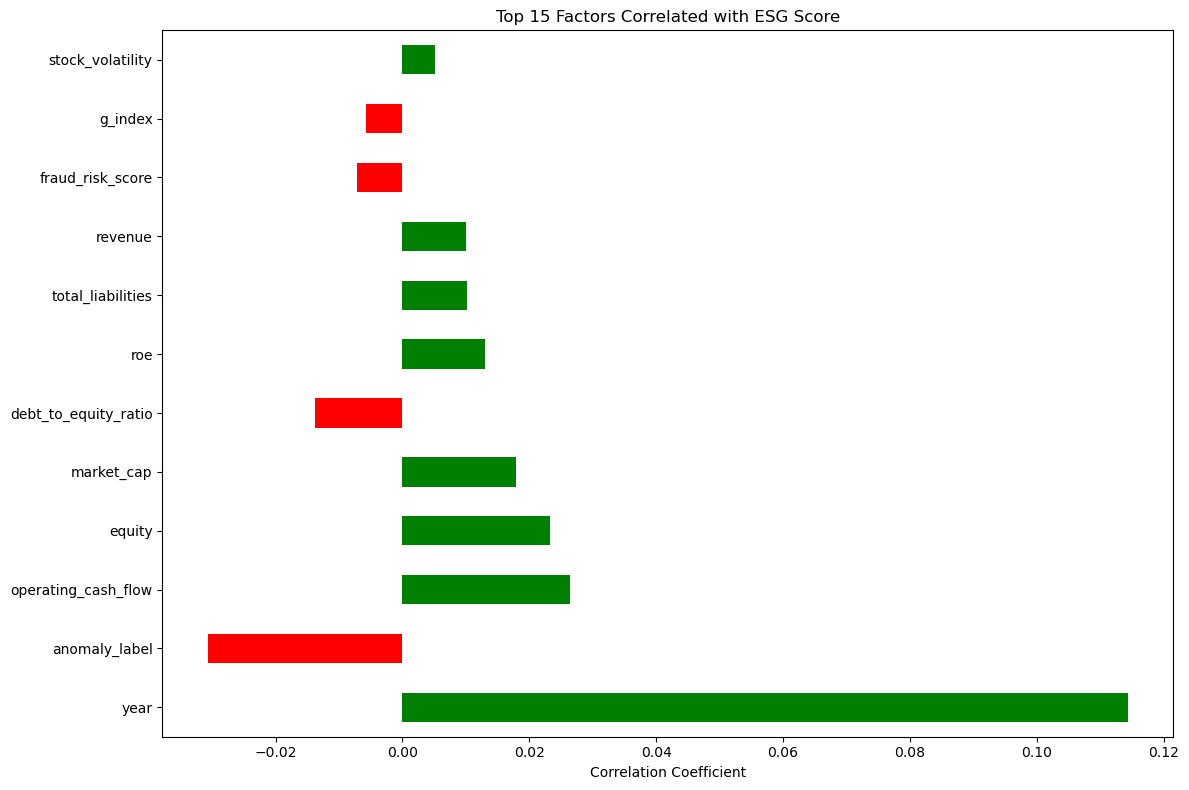

In [161]:
# ESG correlation bar plot
plt.figure(figsize=(12, 8))
correlations_sorted.head(15).plot(kind='barh', color=['green' if x > 0 else 'red' for x in correlations_sorted.head(15)])
plt.title('Top 15 Factors Correlated with ESG Score')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

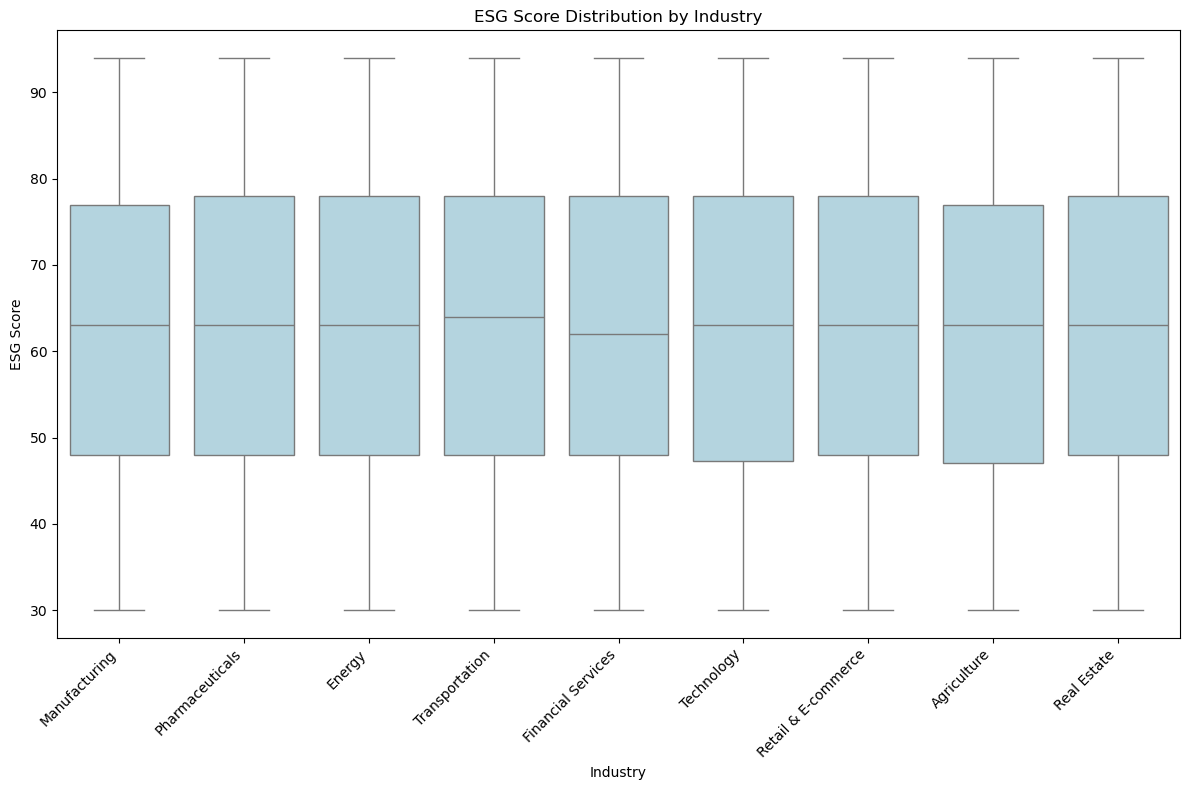

In [178]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=df, x='industry', y='esg_score', color='lightblue')
plt.title('ESG Score Distribution by Industry')
plt.xlabel('Industry')
plt.ylabel('ESG Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

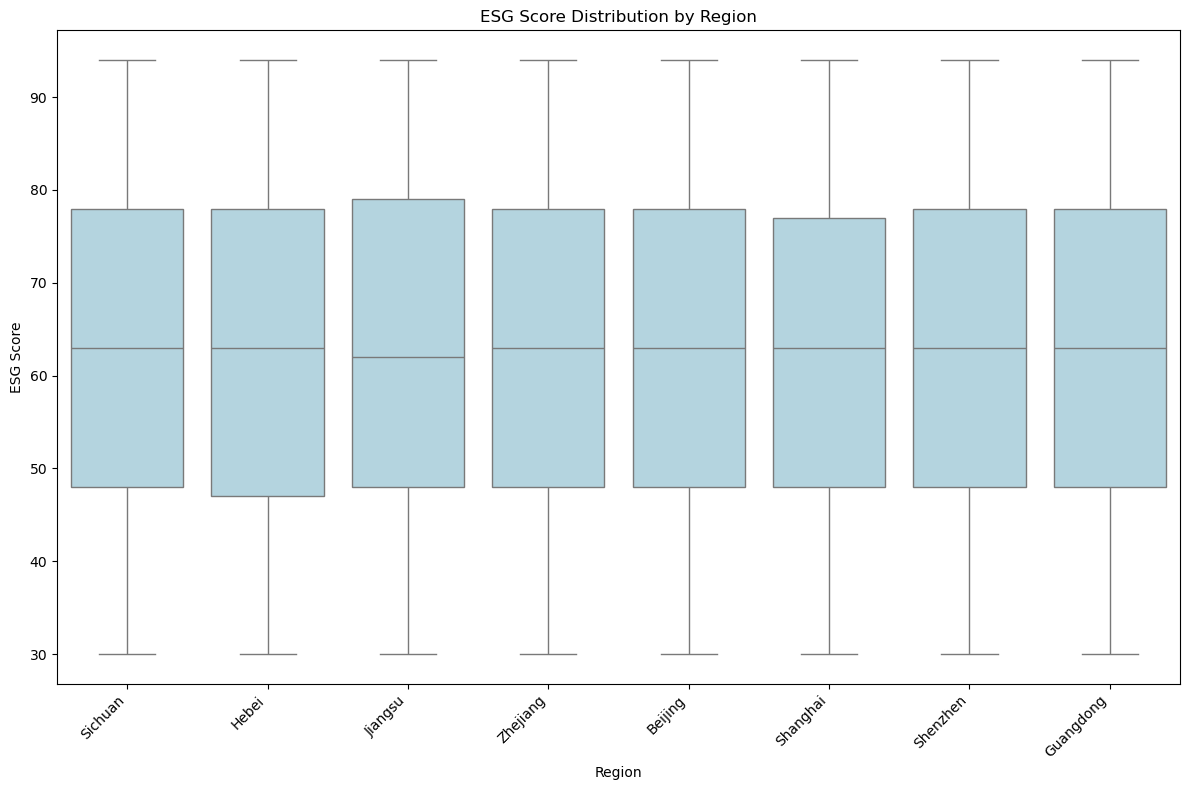

In [180]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=df, x='region', y='esg_score', color='lightblue')
plt.title('ESG Score Distribution by Region')
plt.xlabel('Region')
plt.ylabel('ESG Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [203]:
# 3. Categorical Variable Analysis
print("3. CATEGORICAL VARIABLE IMPACT")

categorical_cols = ['industry', 'region', 'credit_rating', 'audit_opinion', 
                   'ownership_type', 'risk_category', 'audit_firm']

# Remove columns that don't exist in the dataset
categorical_cols = [col for col in categorical_cols if col in df.columns]

for col in categorical_cols:
    # if df[col].nunique() < 20:  # Only analyze if not too many categories
    # avg_esg = df.groupby(col)['esg_score'].agg(['median', 'count']).sort_values('median', ascending=False)
    stats = df.groupby(col)['esg_score'].agg([
        'count',
        ('Q1', lambda x: x.quantile(0.25)),
        'median',
        ('Q3', lambda x: x.quantile(0.75))
    ]).round(0).astype(int)
    print(f"\nESG Score by {col}:")
    print(stats.head(10))

print("\n" + "="*50 + "\n")

3. CATEGORICAL VARIABLE IMPACT

ESG Score by industry:
                     count  Q1  median  Q3
industry                                  
Agriculture           4177  47      63  77
Energy                4170  48      63  78
Financial Services    4110  48      62  78
Manufacturing         4141  48      63  77
Pharmaceuticals       4131  48      63  78
Real Estate           4087  48      63  78
Retail & E-commerce   4241  48      63  78
Technology            4154  47      63  78
Transportation        4114  48      64  78

ESG Score by region:
           count  Q1  median  Q3
region                          
Beijing     4838  48      63  78
Guangdong   4590  48      63  78
Hebei       4644  47      63  78
Jiangsu     4601  48      62  79
Shanghai    4636  48      63  77
Shenzhen    4590  48      63  78
Sichuan     4709  48      63  78
Zhejiang    4717  48      63  78

ESG Score by credit_rating:
               count  Q1  median  Q3
credit_rating                       
A               8

In [ ]:
'''
Primary findings:
- Year: older companies tend to hold higher ESG standards
- Credit rating: borderline companies (rate B) tend to take part in ESG activities to improve their credit performance
- Ownership type: foreign companies follow global standards, resulting in higher ESG
- Industry:
+ Due to high scrutiny, transportation industry has more companies striving to improve their ESG score
+ Financial Services firms struggle with ESG due to downstream dependencies & volatile market situation
https://iacpm.org/wp-content/uploads/2023/05/bain_brief_how-financial-services-firms-wrestle-with-esg.pdf
'''

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Load your data
# df = pd.read_csv('your_data.csv')  # Replace with your actual file path

def explore_esg_factors(df):
    """
    Comprehensive analysis of factors impacting ESG scores
    """
    
    print("=== ESG SCORE IMPACT ANALYSIS ===\n")
    
    # 1. Basic Data Overview
    print("1. DATA OVERVIEW")
    print(f"Dataset shape: {df.shape}")
    print(f"Missing ESG scores: {df['esg_score'].isnull().sum()}")
    print(f"ESG score range: {df['esg_score'].min():.2f} - {df['esg_score'].max():.2f}")
    print(f"ESG score mean: {df['esg_score'].mean():.2f}")
    print("\n" + "="*50 + "\n")
    
    # 2. Correlation Analysis
    print("2. CORRELATION WITH ESG SCORE")
    
    # Identify numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col != 'company_id']
    
    # Calculate correlations with ESG score
    correlations = df[numerical_cols].corr()['esg_score'].drop('esg_score').sort_values(key=abs, ascending=False)
    
    print("Top factors correlated with ESG score:")
    for factor, corr in correlations.head(10).items():
        print(f"{factor:<25}: {corr:>7.3f}")
    
    # Visualization: Correlation heatmap
    plt.figure(figsize=(12, 10))
    corr_matrix = df[numerical_cols].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Numerical Variables')
    plt.tight_layout()
    plt.show()
    
    # ESG correlation bar plot
    plt.figure(figsize=(12, 8))
    correlations.head(15).plot(kind='barh', color=['green' if x > 0 else 'red' for x in correlations.head(15)])
    plt.title('Top 15 Factors Correlated with ESG Score')
    plt.xlabel('Correlation Coefficient')
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*50 + "\n")
    
    # 3. Categorical Variable Analysis
    print("3. CATEGORICAL VARIABLE IMPACT")
    
    categorical_cols = ['industry', 'region', 'credit_rating', 'audit_opinion', 
                       'ownership_type', 'risk_category', 'audit_firm']
    
    # Remove columns that don't exist in the dataset
    categorical_cols = [col for col in categorical_cols if col in df.columns]
    
    for col in categorical_cols:
        if df[col].nunique() < 20:  # Only analyze if not too many categories
            avg_esg = df.groupby(col)['esg_score'].agg(['mean', 'count']).sort_values('mean', ascending=False)
            print(f"\nESG Score by {col.upper()}:")
            print(avg_esg.head(10))
    
    print("\n" + "="*50 + "\n")
    
    # 4. Feature Importance using Random Forest
    print("4. FEATURE IMPORTANCE ANALYSIS")
    
    # Prepare data for modeling
    df_model = df.copy()
    
    # Handle categorical variables
    le = LabelEncoder()
    for col in categorical_cols:
        if col in df_model.columns:
            df_model[col] = le.fit_transform(df_model[col].astype(str))
    
    # Select features (exclude target and ID columns)
    feature_cols = [col for col in df_model.columns if col not in ['esg_score', 'company_id', 'company_name']]
    
    # Remove rows with missing ESG scores
    df_clean = df_model.dropna(subset=['esg_score'])
    
    X = df_clean[feature_cols]
    y = df_clean['esg_score']
    
    # Handle missing values
    X = X.fillna(X.median())
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Random Forest for feature importance
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Feature importance
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Feature Importance (Random Forest):")
    print(importance_df.head(15).to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'], 
             color=['darkgreen' if i < 5 else 'lightgreen' for i in range(len(top_features))])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Most Important Features for ESG Score Prediction')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Model performance
    y_pred = rf.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"\nRandom Forest Model Performance:")
    print(f"R² Score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    
    print("\n" + "="*50 + "\n")
    
    # 5. Linear Regression Analysis
    print("5. LINEAR REGRESSION COEFFICIENTS")
    
    # Standardize features for linear regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit linear regression
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    
    # Get coefficients
    coef_df = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': lr.coef_
    }).sort_values('coefficient', key=abs, ascending=False)
    
    print("Linear Regression Coefficients (standardized):")
    print(coef_df.head(15).to_string(index=False))
    
    # Plot coefficients
    plt.figure(figsize=(12, 8))
    top_coefs = coef_df.head(15)
    colors = ['red' if x < 0 else 'blue' for x in top_coefs['coefficient']]
    plt.barh(range(len(top_coefs)), top_coefs['coefficient'], color=colors)
    plt.yticks(range(len(top_coefs)), top_coefs['feature'])
    plt.xlabel('Standardized Coefficient')
    plt.title('Top 15 Linear Regression Coefficients for ESG Score')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Linear regression performance
    y_pred_lr = lr.predict(X_test_scaled)
    r2_lr = r2_score(y_test, y_pred_lr)
    rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
    
    print(f"\nLinear Regression Model Performance:")
    print(f"R² Score: {r2_lr:.3f}")
    print(f"RMSE: {rmse_lr:.3f}")
    
    print("\n" + "="*50 + "\n")
    
    # 6. Summary and Recommendations
    print("6. SUMMARY & KEY INSIGHTS")
    
    top_rf_features = importance_df.head(5)['feature'].tolist()
    top_corr_features = correlations.head(5).index.tolist()
    
    print("Most Important Features (Random Forest):")
    for i, feature in enumerate(top_rf_features, 1):
        print(f"{i}. {feature}")
    
    print("\nHighest Correlated Features:")
    for i, feature in enumerate(top_corr_features, 1):
        corr_val = correlations[feature]
        print(f"{i}. {feature} (r = {corr_val:.3f})")
    
    print(f"\nModel Comparison:")
    print(f"Random Forest R²: {r2:.3f}")
    print(f"Linear Regression R²: {r2_lr:.3f}")
    
    return {
        'correlations': correlations,
        'feature_importance': importance_df,
        'coefficients': coef_df,
        'rf_model': rf,
        'lr_model': lr,
        'scaler': scaler
    }

# Example usage:
# Uncomment and modify the following lines to use with your data

"""
# Load your dataset
df = pd.read_csv('your_esg_data.csv')  # Replace with your file path

# Run the analysis
results = explore_esg_factors(df)

# Access individual results if needed
# print("Top 5 most important features:")
# print(results['feature_importance'].head())
"""

print("Code ready! Load your dataset and call explore_esg_factors(df) to run the analysis.")
print("\nMake sure your dataset has the following columns:")
print("- esg_score (target variable)")
print("- All the attributes you mentioned in your list")
print("\nThe analysis will provide:")
print("1. Correlation analysis")
print("2. Categorical variable impact")
print("3. Feature importance using Random Forest")
print("4. Linear regression coefficients")
print("5. Visual plots and model performance metrics")

Code ready! Load your dataset and call explore_esg_factors(df) to run the analysis.

Make sure your dataset has the following columns:
- esg_score (target variable)
- All the attributes you mentioned in your list

The analysis will provide:
1. Correlation analysis
2. Categorical variable impact
3. Feature importance using Random Forest
4. Linear regression coefficients
5. Visual plots and model performance metrics
